use python3

# Preamble

In [1]:
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import xarray as xr
import pandas as pd
import numpy as np
from scipy import integrate

In [2]:
def dpdz(p, z, g, R, SST, c_p, H0):
    return -(p * g) / (R * ( SST - 0.5 - (g*z)/c_p) )

# Composite trapezoidal rule for numerical integration
def trapezoidal_rule(p_initial, z_values, dz, g, R_values, SST, c_p, H0):
    p_values = [p_initial]

    for i in range(1, len(z_values)):
        # Update the temperature and R_d for each integration step
        z_current = z_values[i - 1]
        R_current = R_values[i - 1,:]

        # Update pressure using the composite trapezoidal rule
        p_new = p_values[-1] + 0.5 * ( dpdz(p_values[-1], z_current, g, R_current, SST, c_p, H0) + dpdz(p_values[-1] + dpdz(p_values[-1], z_current, g, R_current, SST, c_p, H0) * dz[i], z_values[i], g, R_values[i], SST, c_p, H0)) * dz[i]
        p_values.append(p_new)

    return p_values

In [3]:
from scipy.interpolate import NearestNDInterpolator
def interpolate_field_lon_lat(field, lon_coord="clon", lat_coord="clat", relative_resolution=1.5):
    nlon = nlat = int(np.sqrt(len(field) * relative_resolution))  # maybe make this more configurable
    
    lon_points = field[lon_coord].values
    lat_points = field[lat_coord].values
    
    lon = np.linspace(np.min(lon_points), np.max(lon_points), nlon)
    lat = np.linspace(np.min(lat_points), np.max(lat_points), nlat)
    lon2, lat2 = np.meshgrid(lon, lat)
    
    points = np.stack((lon_points, lat_points), axis=1)
    return xr.DataArray(
        NearestNDInterpolator(points, field.values)(lon2, lat2),
        dims=["lat", "lon"],
        coords={"lon": lon, "lat": lat})

In [4]:
ocean_type = 'atlantic'
dpp        = 'ngc2009'
year       = '2020'
season     = 'SON'

In [5]:
from box_coordinates_and_paths import choose_region

degrees_lower_box_bound, degrees_upper_box_bound, degrees_left_box_bound, degrees_right_box_bound = choose_region(ocean_type)
print(ocean_type, 'with:', choose_region(ocean_type))

atlantic with: (-5, 5, -40, 10)


# Data

In [6]:
datapath = "/work/mh0731/m300868/00_DATA/Paper_Data/"

In [7]:
data = xr.open_dataset(datapath+f'07_fig_data_{ocean_type}_at_top_of_ABL.nc')
### recovering the boolean in the valid and mask arrays
data = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop_vars({'valid', 'valid_oce', 'mask', 'mask_oce'})])
data_rho = xr.open_dataset(datapath+'07_fig_rho_data_atlantic.nc')
data_pfull = xr.open_dataset(datapath+'07_fig_pfull_data_atlantic.nc')
grid = xr.open_dataset(datapath+f'02_fig_grid_info_{ocean_type}.nc')
ocean_grid = xr.open_dataset(datapath+f'07_fig_ocean_grid_info_{ocean_type}.nc')

In [8]:
mean_cell_height = xr.open_dataset(datapath+'02_fig_mean_cell_height_in_meter.nc').cell_height

In [9]:
valid     = data.valid.values
valid_oce = data.valid_oce.values

mask      = data.mask.values
mask_oce  = data.mask_oce.values

two_to_two_mask = np.where((grid.sel(cell=valid).sel(cell=mask).clat < np.deg2rad(2)) & (grid.sel(cell=valid).sel(cell=mask).clat > np.deg2rad(-2)), True, False)

In [10]:
##### H0 Determination

datapath_ABL = "/work/mh0731/m300868/00_DATA/Paper_Data_Revised/"

seasons_df = pd.read_csv(datapath_ABL+'top_of_ABL_combined_review.csv', index_col=0)
print(seasons_df)

top_of_ABL = seasons_df.loc[f'{ocean_type}'][f'{year}-{season}']

print('!!! TOP OF ABL !!! = ', top_of_ABL)

                 2020-MAM  2020-JJA  2020-SON  2021-DJF  2021-MAM  2021-JJA   
western_pacific         8         8         8         7         8         8  \
central_pacific         8         8         8         8         8         8   
eastern_pacific        11        11        13        11        11        12   
indian_ocean            7         7         8         9         8         8   
atlantic                9        10        13        11         9         7   

                 2021-SON  2022-DJF  
western_pacific         8         7  
central_pacific         8         8  
eastern_pacific        12        11  
indian_ocean            7        12  
atlantic               14         9  
!!! TOP OF ABL !!! =  13


## Hydrostatic Surface Pressure

In [11]:
g_value = 9.787 

### ICON

In [12]:
integral_rho_g = integrate.trapz(np.multiply(data_rho.rho[::-1,:], g_value), x=mean_cell_height[:21], axis=0)
last_level_prs = data_pfull.pfull.isel(height=0).values
p0_hydro       = np.add(integral_rho_g, last_level_prs)

In [13]:
p0_ICON_hydro_da = xr.DataArray(p0_hydro,
                           coords={'clon':data_pfull.clon, 'clat':data_pfull.clat}, 
                           dims=['cell'], 
                           name="p0_hydro_da")

### from SST

In [14]:
H0_value  = mean_cell_height.isel(height=top_of_ABL).item()
rho_mean  = data.rho_3d.isel(height=slice(0,top_of_ABL+1))
prs_mean  = data.pressure_fields.isel(height=slice(0,top_of_ABL+1))
AirT_mean = data.ta.isel(height=slice(0,top_of_ABL+1))
R_field   = (prs_mean / (rho_mean * AirT_mean)).rename({'all_cells':'cell'}).sel(cell=valid).sel(cell=mask)
SST       = (data.to+273.15).rename({'all_oce_cells':'cell'}).sel(cell=valid_oce).sel(cell=mask_oce)

ICON_ABL_prs_field = data.pressure_fields.sel(all_cells=valid).sel(all_cells=mask).sel(height=top_of_ABL) 
ICON_ABL_prs_mean  = ICON_ABL_prs_field.mean(dim='all_cells')
ICON_ABL_prs       = xr.full_like(ICON_ABL_prs_field, fill_value=ICON_ABL_prs_mean).rename({'all_cells':'cell'})

z = mean_cell_height.isel(height=slice(0,top_of_ABL+1))
z_extended = xr.concat([xr.DataArray([0], dims='height'), z], dim='height')

In [15]:
p_init = ICON_ABL_prs.mean()
z      = z
dz     = -np.diff(z_extended)
g      = g_value
R      = R_field
SST    = SST
c_p    = 1005
H0     = H0_value

pressure_values = trapezoidal_rule(p_init, z, dz, g, R, SST, c_p, H0)

In [16]:
p0_LN_hydro_da = xr.DataArray(pressure_values[-1],
                           coords={'clon':ocean_grid.clon.sel(cell=valid_oce).sel(cell=mask_oce), 'clat':ocean_grid.clat.sel(cell=valid_oce).sel(cell=mask_oce)}, 
                           dims=['cell'], 
                           name="ICON_sfc_prs")

# Statistics

In [20]:
LN_hydro   = (p0_LN_hydro_da.sel(cell=two_to_two_mask)/100)
ICON_hydro = (p0_ICON_hydro_da.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask)/100)      

In [21]:
LN_ICON_diff = (LN_hydro - ICON_hydro)

In [24]:
LN_ICON_diff.mean()

<xarray.DataArray ()> Size: 8B
array(2.65362748)

In [22]:
LN_ICON_diff.min()

<xarray.DataArray ()> Size: 8B
array(1.58777232)

In [23]:
LN_ICON_diff.max()

<xarray.DataArray ()> Size: 8B
array(11.75676979)

# Plotting

In [17]:
SIZE = 35
plt.rcParams['axes.labelsize']  = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['xtick.labelsize'] = SIZE
plt.rcParams['ytick.labelsize'] = SIZE
plt.rcParams['font.size']       = SIZE

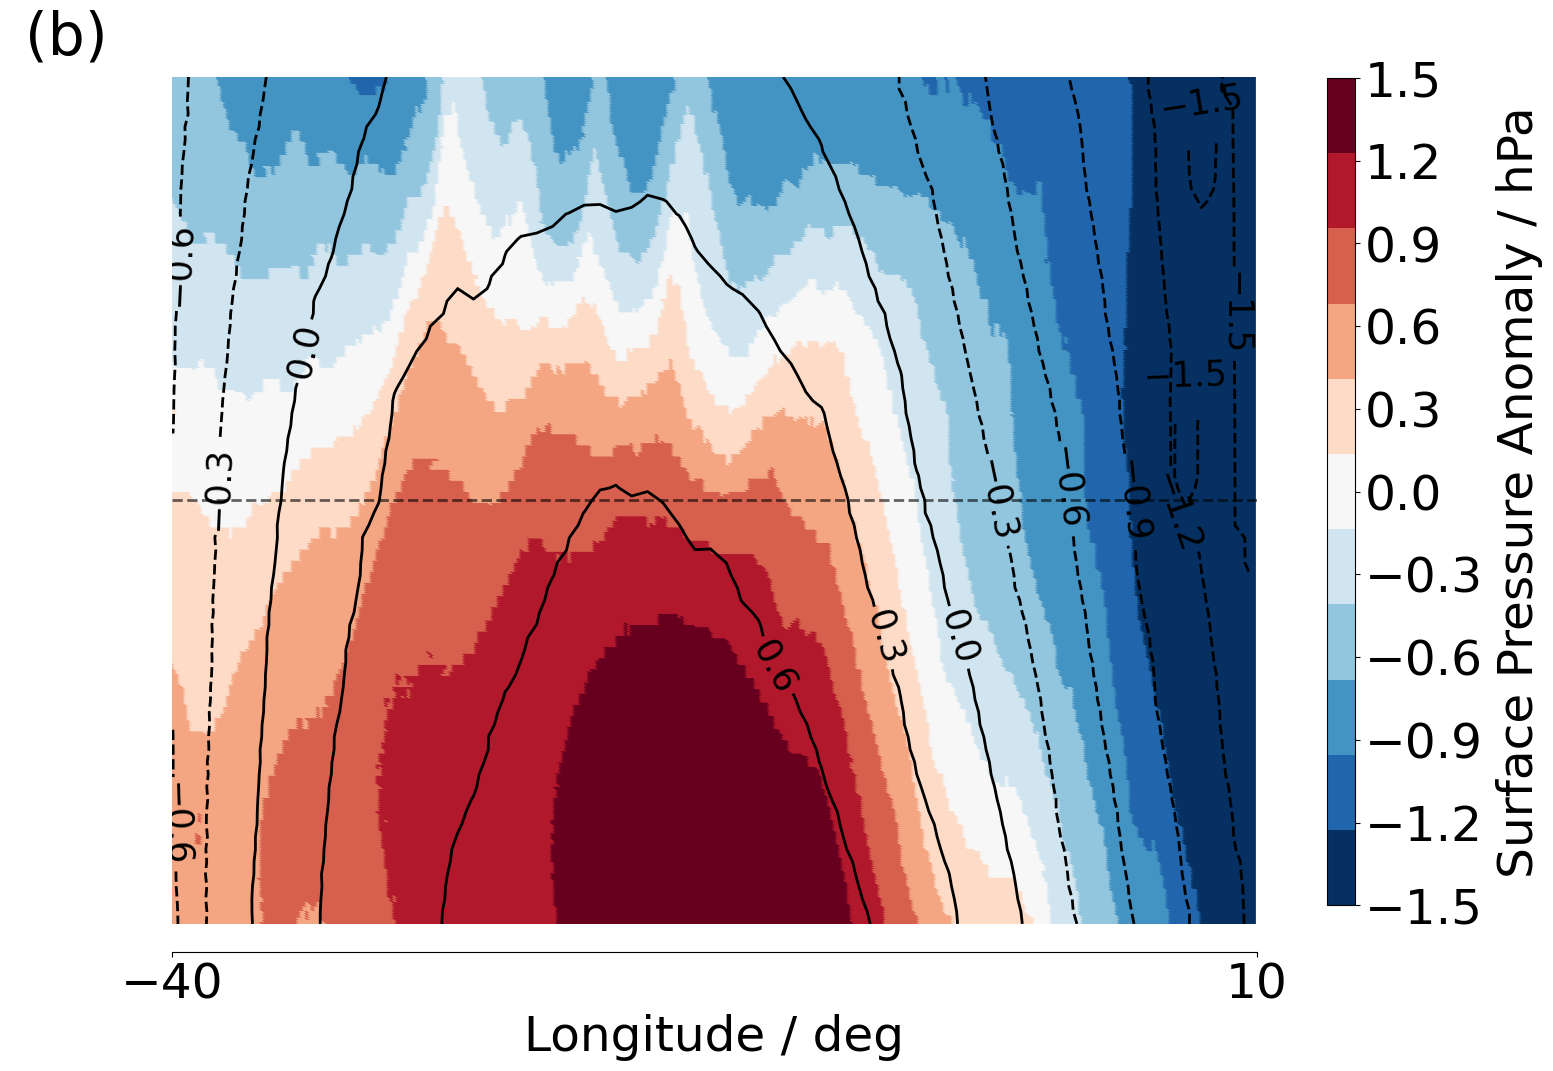

In [18]:
fig = plt.figure(figsize=(14,11), facecolor='w', edgecolor='k')
G = gridspec.GridSpec(1,1)

VMIN = -1.5
VMAX = 1.5

ax = plt.subplot(G[0,0])

DATA_ARRAY_1 = -((p0_LN_hydro_da.sel(cell=two_to_two_mask).mean()/100) - (p0_LN_hydro_da.sel(cell=two_to_two_mask)/100))
DATA_ARRAY_2 = -((p0_ICON_hydro_da.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask).mean()/100) - (p0_ICON_hydro_da.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask)/100))

DATA_ARRAY_2 = DATA_ARRAY_2[DATA_ARRAY_2 > -2.5]

### western_pacific specialisation
if degrees_left_box_bound > degrees_right_box_bound:
    DATA_ARRAY_1 = DATA_ARRAY_1.assign_coords(clon=np.deg2rad(((np.rad2deg(DATA_ARRAY_1.clon) + 360) % 360)))
    DATA_ARRAY_2 = DATA_ARRAY_2.assign_coords(clon=np.deg2rad(((np.rad2deg(DATA_ARRAY_2.clon) + 360) % 360)))
    ax.set_xlim(degrees_left_box_bound, degrees_left_box_bound+50)
    ax.set_xticks([150, 200])
    ax.set_xticklabels(['150', '-160'])
else:
    DATA_ARRAY_1 = DATA_ARRAY_1
    DATA_ARRAY_2 = DATA_ARRAY_2
    ax.set_xlim(degrees_left_box_bound, degrees_right_box_bound)
    ax.set_xticks([degrees_left_box_bound, degrees_right_box_bound])
    
    
INPUT = interpolate_field_lon_lat(DATA_ARRAY_1)
lon_INPUT, lat_INPUT = np.meshgrid(np.rad2deg(INPUT.lon), np.rad2deg(INPUT.lat))

ax.axhline(0, color='black', ls='dashed', lw=2, alpha=0.6)

im = ax.scatter(lon_INPUT, lat_INPUT, c=INPUT, 
                 cmap=plt.cm.get_cmap('RdBu_r',11), vmin=VMIN, vmax=VMAX)

cb_ax = fig.add_axes([0.95, 0.127, 0.02, 0.752])
cbar = fig.colorbar(im, orientation='vertical', cax=cb_ax)

custom_levels = [VMIN,-1.2,-0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2, VMAX]

cbar.ax.set_yticks(custom_levels)
cbar.set_label(r'Surface Pressure Anomaly / hPa', rotation=90, labelpad=10)

INPUT = interpolate_field_lon_lat(DATA_ARRAY_2, relative_resolution=0.05)
lon_INPUT, lat_INPUT = np.meshgrid(np.rad2deg(INPUT.lon), np.rad2deg(INPUT.lat))
contours = ax.contour(lon_INPUT, lat_INPUT, INPUT.data, levels=custom_levels, colors='k', linewidths=2)
ax.clabel(contours, inline=True, fontsize=25)

ax.set_yticks([-2, 0, 2])
ax.set_ylim(-2, 2)
ax.spines[['left']].set_visible(True)
ax.spines['left'].set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')

ax.set_ylabel('Latitude / deg', rotation=90)
ax.set_xlabel('Longitude / deg')
ax.spines[['left', 'bottom']].set_position(('outward',20))
ax.spines[['bottom']].set_visible(True)
ax.spines[['top', 'right']].set_visible(False)

plt.text(0.02, 0.9, '(b)', fontsize=42, transform=plt.gcf().transFigure)

filename = f'fig_07_01.png'
filepath = 'figs_review/'
plt.savefig(filepath + filename, facecolor='white', bbox_inches='tight', dpi=400)

plt.show()

In [19]:
from PIL import Image

# Paths to your PNG files
png1_path = "figs_review/fig_07_00.png"
png2_path = "figs_review/fig_07_01.png"
output_image = "figs_review/fig_07_revised.pdf"

# Slide parameter (positive values slide image2 over image1 to the left)
SLIDE = 900

# Open both images
image1 = Image.open(png1_path)
image2 = Image.open(png2_path)

# Get the width and height of each image
width1, height1 = image1.size
width2, height2 = image2.size

# Create a new image with the combined width (accounting for SLIDE) and the max height of both images
new_width = width1 + width2 - SLIDE
new_height = max(height1, height2)

# Create a new blank image with the combined size
new_image = Image.new('RGB', (new_width, new_height), (255, 255, 255))  # White background

# Paste image1 on the left
new_image.paste(image1, (0, 0))

# Paste image2 slightly overlapping image1 to the right
new_image.paste(image2, (width1 - SLIDE, 0))

# Save the combined image as a new file
new_image.save(output_image)

print(f"Images merged successfully into {output_image}")

Images merged successfully into figs_review/fig_07_revised.pdf
